# Shared Interest XAITK Integration Example <a name="XAITK-Saliency-Shared-Interest"></a>
This example notebook makes use of the base [shared-interest](https://github.com/mitvis/shared-interest/blob/main/shared_interest/examples/shared_interest_example.ipynb) example and explores integrating ``xaitk-saliency``, followed by computing the shared interest scores on the generated saliency maps.

## Set Up Environment <a name="Set-Up-Environment-Shared-Interest"></a>

In [ ]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q torch==1.12.0
!{sys.executable} -m pip install -q torchvision==0.13.0
!{sys.executable} -m pip install -q tqdm
!{sys.executable} -m pip install -q captum

## Clone Repo and Install Shared-Interest <a name="Clone-and-Install-Shared-Interest"></a>

In [ ]:
%%bash

git clone https://github.com/mitvis/shared-interest.git
cd shared-interest
pip install -e git+https://github.com/mitvis/shared-interest.git#egg=shared_interest

## Load Model and Setup Transforms <a name="Model-Transforms-Shared-Interest"></a>

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import PIL.Image

CUDA_AVAILABLE = torch.cuda.is_available()
model = models.resnet50(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]

model_loader = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(256),
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=model_mean,
                                std=[0.229, 0.224, 0.225])])

img_loader = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=model_mean,
                                std=[0.229, 0.224, 0.225])])

ground_truth_transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.Resize(256, PIL.Image.NEAREST),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor()])

reverse_image_transform = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], 
                                                                   std=[4.3668, 4.4643, 4.4444]),
                                              transforms.Normalize(mean=[-0.485, -0.456, -0.406], 
                                                                   std=[1, 1, 1]),
                                              transforms.ToPILImage(),])

/data/barry.ravichandran/envs/shared_interest/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/barry.ravichandran/envs/shared_interest/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/barry.ravichandran/envs/shared_interest/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Configure ImageNet Dataloader <a name="ImageNet-DataLoader-Shared-Interest"></a>

In [2]:
import os
import torch.utils.data
from shared_interest.datasets.imagenet import ImageNet # type: ignore

imagenet_dir = './data/input'
image_dir = os.path.join(imagenet_dir, 'images')
annotation_dir = os.path.join(imagenet_dir, 'annotations')
dataset = ImageNet(image_dir, annotation_dir, img_loader, ground_truth_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False,
                                         num_workers=40, pin_memory=True)

## Configure Class labels for ImageNet subset <a name="Class-Labels-Shared-Interest"></a>

In [3]:
import urllib.request

def get_sal_labels(classes_file, custom_categories_list=None):
    if not os.path.isfile(classes_file):
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        _ = urllib.request.urlretrieve(url, classes_file)
    
    f = open(classes_file, "r")
    categories = [s.strip() for s in f.readlines()]
    
    if not custom_categories_list == None:
        sal_class_labels = custom_categories_list
    else:
        sal_class_labels = categories
    
    sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]
    
    return sal_class_labels, sal_class_idxs

data_path = "./data"
if not os.path.exists(data_path):
    os.makedirs(data_path)

classes_file = os.path.join(data_path,"imagenet_classes.txt")
sal_class_labels, sal_class_idxs = get_sal_labels(classes_file,['boxer', 'tiger cat', 'cock'])

## SMQTK Classifier Wrapper <a name="SMQTK-Classifier-Shared-Interest"></a>

In [4]:
import numpy as np
import torch.nn.functional
from smqtk_classifier.interfaces.classify_image import ClassifyImage

class TorchResnet (ClassifyImage):

    def get_labels(self):
        return sal_class_labels
    
    @torch.no_grad()
    def classify_images(self, image_iter):
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.
        
        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            
            feature_vec = model(image_tensor)
            
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    def get_config(self):
        
        return {}

blackbox_classifier, blackbox_fill = TorchResnet(), np.uint8(np.asarray(model_mean) * 255).tolist()

## Initialize Saliency Algorithm <a name="Saliency-Algorithm-Shared-Interest"></a>

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack

sal_generator = RISEStack(
            n=200,
            s=8,
            p1=0.5,
            seed=1,
            threads=4,
            debiased=True
        )
sal_generator.fill = blackbox_fill

## Modified ``run`` function that swaps in the ``xaitk-saliency`` method <a name="Swap-Saliency-Shared-Interest"></a>

In [6]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from shared_interest.shared_interest import shared_interest # type: ignore
from shared_interest.util import flatten, binarize_std # type: ignore

def run(model, dataloader, saliency_method, stop_after=None):
    
    device = "cpu"
    if CUDA_AVAILABLE:
        device = "cuda"
        
    accuracy = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    
    total_predictions = np.array([])
    total_saliency_masks = np.array([[[]]])
    
    for i, (images, ground_truth, labels) in enumerate(tqdm(dataloader)):
        
        sal_maps = np.empty((0,len(sal_class_labels),224,224))
        
        with torch.no_grad():
            ground_truth = ground_truth.numpy()
            labels = labels.numpy()
            images = images.to(device)
            
            # Compute model predictions
            output = model(images)
            predictions = torch.argmax(output, dim=1).detach().cpu().numpy()
            total_predictions = np.concatenate((total_predictions, predictions))

            # Update metrics
            accuracy += accuracy_score(labels, predictions)
        
        # Compute saliency
        im_numpy = images.cpu().numpy().astype("uint8")
        for img in im_numpy:
            img = img.transpose((1,2,0))
            sal_map = saliency_method(img, blackbox_classifier)
            sal_map = np.expand_dims(sal_map,axis=0)
            sal_maps = np.vstack((sal_maps,sal_map))
            
        saliency = flatten(sal_maps)
        saliency_masks = binarize_std(saliency)
        
        if i == 0:
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
        
        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))

        # Stop early for this example notebook
        if stop_after and i == stop_after:
            break
    accuracy /= (i + 1) # type: ignore
    print('Accuracy: %.2f' %accuracy)
    return total_saliency_masks, total_shared_interest_scores, total_predictions

saliency_masks, shared_interest_scores, predictions = run(model, dataloader, sal_generator, stop_after=0)

100%|██████████| 1/1 [00:12<00:00, 12.31s/it]

Accuracy: 1.00


## Saliency Visualization with Shared Interest Scores <a name="Saliency-Scores-Shared-Interest"></a>

In [7]:
import matplotlib.pyplot as plt

def ax_off(ax):
    ax.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
    )

def display_images(data_inds, dataset):
    data = [dataset[i] for i in data_inds]
    n = len(data)
    fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(10,4*n))
    np.vectorize(ax_off)(ax)
    
    for i, (image, ground_truth, label) in enumerate(data):
        data_ind = data_inds[i]
        ax[i][0].imshow(reverse_image_transform(image))
        ax[i][0].set_title('Image\nLabel: %s Pred: %s' %(label, int(predictions[data_ind])))

        masked_image = image * ground_truth.unsqueeze(0)
        ax[i][1].imshow(reverse_image_transform(masked_image))
        ax[i][1].set_title('Ground Truth\n')
        
        saliency_image = np.array(reverse_image_transform(image)) * np.expand_dims(saliency_masks[data_ind], axis=2)
        ax[i][2].imshow(saliency_image)
        ax[i][2].set_title('Saliency\nIoU: %.1f SC: %.1f GTC: %.1f'
                    %(shared_interest_scores['iou_coverage'][data_ind],
                      shared_interest_scores['saliency_coverage'][data_ind],
                      shared_interest_scores['ground_truth_coverage'][data_ind],
                     ))
    return fig

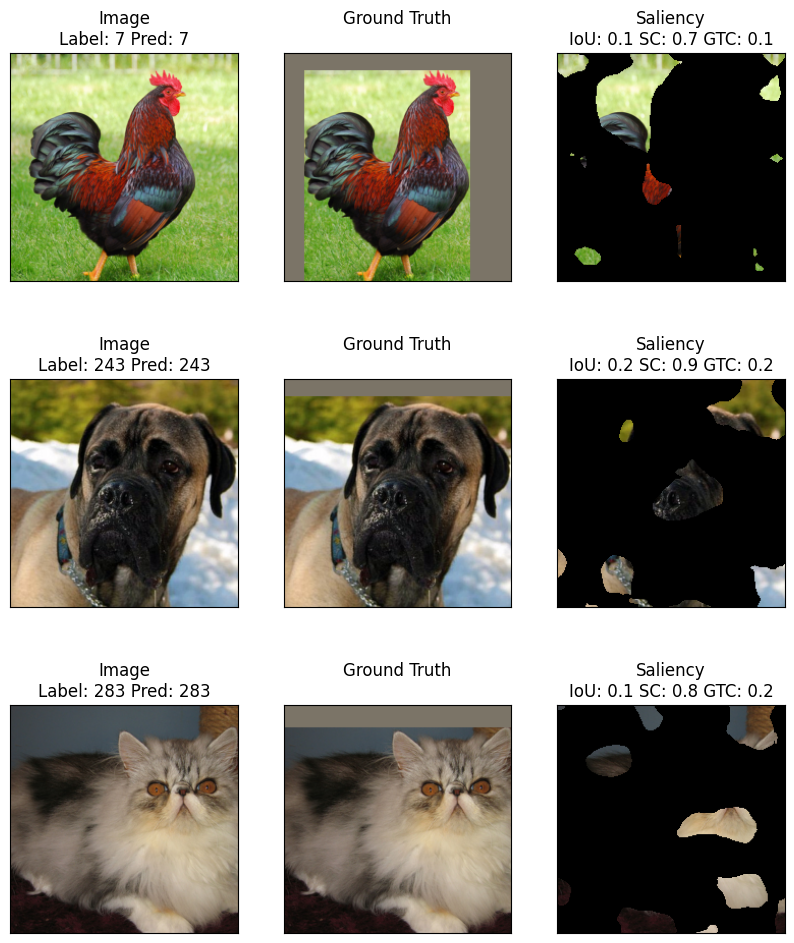

In [8]:
fig = display_images(list(range(0,3)), dataset)